Import the main libraries for this project

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sklearn.impute as imp

Load the datasets to analize them separately

In [34]:
# Let's make a preliminary analysis to the datasets
races_df = pd.read_csv("./dataset/races.csv")
cyclist_df = pd.read_csv("./dataset/cyclists.csv")

# Ciclist table preliminary analysis
The key for cyclist table is column **_url** that is the name of the cyclist, while in races table the column **cyclist** is a foreign key

In [35]:
def check_key(df, column_name):
    # Check if there are no NaN values and if all values are unique
    return df[column_name].notna().all() and df[column_name].is_unique


def check_in(df1, df2, col1, col2):
    return df1[col1].isin(df2[col2]).all()


print(
    check_key(cyclist_df, "_url")
)  # This column is a key for clyclist dataset
print(
    check_in(races_df, cyclist_df, "cyclist", "_url")
)  # These columns can be used for join

True
True


Some columns have missing values in the cyclist table. For birth_year and nationality we can try to fix them, while we cannot fix weight and height columns since they are NaN for half of the table.

In [36]:
cyclist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


Only cyclist **scott-davies** has missing nationality. We can fix its nationality and birth_year by looking on the web.

In [37]:
# Only one cyclist has nan nationality.
print(
    cyclist_df.loc[cyclist_df.nationality[cyclist_df.nationality.isna()].index]
)


def fix_cyclist(df):
    mask = df["nationality"].isna()
    cyclists = set(df.loc[mask, "_url"])
    for c in cyclists:
        mask = df["_url"] == c
        df.loc[mask, "nationality"] = "Britain"
        df.loc[mask, "birth_year"] = 1995


# Fix using Wikipedia
fix_cyclist(cyclist_df)
print(
    cyclist_df.loc[
        cyclist_df.nationality[cyclist_df._url == "scott-davies"].index
    ]
)

           _url           name  birth_year  weight  height nationality
9  scott-davies  Scott  Davies         NaN     NaN     NaN         NaN
           _url           name  birth_year  weight  height nationality
9  scott-davies  Scott  Davies      1995.0     NaN     NaN     Britain


These cyclist instead have missing birth_year, they are few we can try to fix them.

In [38]:
cyclist_df.loc[cyclist_df.birth_year[cyclist_df.birth_year.isna()].index]

,_url,name,birth_year,weight,height,nationality
601,vladimir-malakov,Vladimir Malakov,NaN,NaN,NaN,Russia
894,antonio-zanini,Antonio Zanini,NaN,NaN,NaN,Italy
2408,filippo-simonetti,Filippo Simonetti,NaN,NaN,NaN,Italy
2515,carlos-garcia,Carlos García,NaN,NaN,NaN,Spain
2536,alexandr-osipov,Alexandr Osipov,NaN,NaN,NaN,Russia
3046,nicolai-kosyakov,Nicolai Kosyakov,NaN,NaN,NaN,Russia
3551,nevens-guy,Guy Nevens,NaN,NaN,NaN,Belgium
4142,oscar-pumar,Oscar Pumar,NaN,NaN,NaN,Venezuela
4384,javier-luquin,Javier Luquin,NaN,NaN,NaN,Spain
4756,thierry-lauder,Thierry Lauder,NaN,NaN,NaN,France


Eliminate cyclists that do not participate in any race

In [7]:
nan_merge_df = pd.merge(
    races_df, cyclist_df, left_on="cyclist", right_on="_url", how="outer"
)
bad_cyclists = nan_merge_df.loc[nan_merge_df._url_x.isna(), "_url_y"].unique()

print(cyclist_df.shape)
cyclist_df = cyclist_df.loc[~cyclist_df._url.isin(bad_cyclists)]
cyclist_df.shape

(6134, 6)


(6095, 6)

# Races table preliminary analysis
Some columns have missing values in races table (**points**, **uci_points**, **climb_total**, **profile**, **average_temperature**, **cyclist_age**, **cycilist_team**).

We can try to fix columns **points**, **cyclist_age** since there are few missing values.
We can drop the column **average_temperature** since there are too many missing values.
We can try to analyze the distribution of **climb_total** over **profile** to try to esitimate and fix the columns.
We can assume that missing values if **cyclist_team** implies 'No team'

In [ ]:
races_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url                 589865 non-null  object 
 1   name                 589865 non-null  object 
 2   points               589388 non-null  float64
 3   uci_points           251086 non-null  float64
 4   length               589865 non-null  float64
 5   climb_total          442820 non-null  float64
 6   profile              441671 non-null  float64
 7   startlist_quality    589865 non-null  int64  
 8   average_temperature  29933 non-null   float64
 9   date                 589865 non-null  object 
 10  position             589865 non-null  int64  
 11  cyclist              589865 non-null  object 
 12  cyclist_age          589752 non-null  float64
 13  is_tarmac            589865 non-null  bool   
 14  is_cobbled           589865 non-null  bool   
 15  is_gravel        

There is some noise in the date we can remove the hours, minutes and seconds of start of the races

In [ ]:
# Let's remove the noise from dates of races
def reformat_dates(df):
    df["date"] = pd.to_datetime(df["date"])
    return df["date"].dt.date


races_df["date"] = reformat_dates(races_df)
print(races_df["date"].unique())

[datetime.date(1978, 7, 5) datetime.date(2016, 9, 3)
 datetime.date(2019, 7, 28) ... datetime.date(1976, 3, 9)
 datetime.date(2016, 3, 27) datetime.date(2010, 5, 8)]


### Resolve NaN points

We can try to check if **points** column is mutually eclusive with **uci_points** column. They aren't

In [ ]:
# Points and UCI_Points are not mutually exclusive columns
def are_xor_columns(df, col1, col2):
    mask = df[col1].isna() ^ df[col2].isna()
    res = df.loc[mask, "cyclist"].tolist()
    return len(res) == len(df)


print(are_xor_columns(races_df, "points", "uci_points"))

False


In [11]:
races_df.loc[races_df.points.isna()]._url.unique()
miss_points_dict = {
    "vuelta-a-espana/1994/stage-5": 80,
    "tour-de-france/1986/stage-19": 100,
    "tour-de-france/1988/prologue": 100,
    "tour-de-france/2019/stage-19": 100,
}

for k, v in miss_points_dict.items():
    mask = races_df._url == k
    races_df.loc[mask, "points"] = v

# convert to int
races_df["points"] = races_df["points"].astype(int)

### Resolve is_tarmac (TODO)

**is_cobbled** and **is_gravel** are all false (we can drop them).
**is_tarmac** is sometimes true and false. It's ok but when it's false also the other columns are false (Noise!!). 

In [ ]:
# Some columns are all False
print(races_df.is_cobbled.unique())
print(races_df.is_gravel.unique())
print(races_df.is_tarmac.unique())

[False]
[False]
[ True False]


### Resolve Deltas (DONE IN SCRAPING)

The delta column have some negative values and also the delta is 0 for many positions different from 0 (Very noisy column!!)

In [ ]:
# A column has inconsistent values. (Negative delta)
print(sorted(races_df.delta.unique())[:100])
# Replace negative values with nan
races_df["delta"] = races_df["delta"].mask(races_df["delta"] < 0, np.nan)

[np.float64(-6906.0), np.float64(-5562.0), np.float64(-2937.0), np.float64(-2638.0), np.float64(-2635.0), np.float64(-2574.0), np.float64(-2567.0), np.float64(-2564.0), np.float64(-2560.0), np.float64(-2550.0), np.float64(-2546.0), np.float64(-2545.0), np.float64(-2542.0), np.float64(-2541.0), np.float64(-2514.0), np.float64(-2513.0), np.float64(-2510.0), np.float64(-2509.0), np.float64(-2505.0), np.float64(-2504.0), np.float64(-2500.0), np.float64(-2487.0), np.float64(-2486.0), np.float64(-2485.0), np.float64(-2482.0), np.float64(-2481.0), np.float64(-2479.0), np.float64(-2477.0), np.float64(-2475.0), np.float64(-2473.0), np.float64(-2469.0), np.float64(-2457.0), np.float64(-2448.0), np.float64(-2446.0), np.float64(-2444.0), np.float64(-2440.0), np.float64(-2438.0), np.float64(-2437.0), np.float64(-2434.0), np.float64(-2432.0), np.float64(-2430.0), np.float64(-2428.0), np.float64(-2425.0), np.float64(-2424.0), np.float64(-2419.0), np.float64(-2416.0), np.float64(-2413.0), np.float64(-

### Resolve positions

First position in a race is 0. We can check it looking on the web.

In [ ]:
# First position in a race is 0. Delta is always 0 for position 0 and different from 0 for position. Checked using Internet
delta0 = ((races_df["position"] == 0) & (races_df["delta"] == 0)).sum()
delta1 = ((races_df["position"] == 1) & (races_df["delta"] == 0)).sum()
print(delta0)
print(delta1)

# Much Much noise in delta column. All positions have some 0 deltas
positions = sorted(races_df.loc[races_df["delta"].isna(), "position"].unique())
print(positions)
positions = sorted(races_df.loc[races_df["delta"] == 0, "position"].unique())
print(positions)

5281
2738
[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70), np.int64(71), np.i

Some positions are duplicate. since we cannot infer in any way which is the real one, remove both

In [15]:
races_df.drop_duplicates(
    subset=races_df.columns.difference(["position"]), keep=False, inplace=True
)

### Resolve profiles and total_climb

Some races have missing profiles. Try to fix looking to the climb_total distribution

In [ ]:
# Profile is numerical (difficulty of trace) missing for some races
print(races_df.profile.unique())

[ 1.  5. nan  3.  2.  4.]


<Axes: xlabel='profile', ylabel='climb_total'>

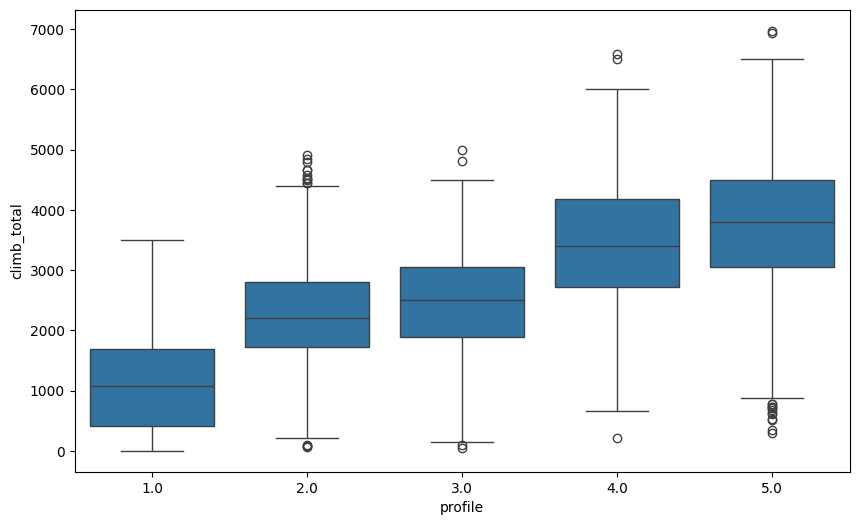

In [80]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=races_df.groupby("_url")[["profile", "climb_total"]].first(),
    x="profile",
    y="climb_total",
)

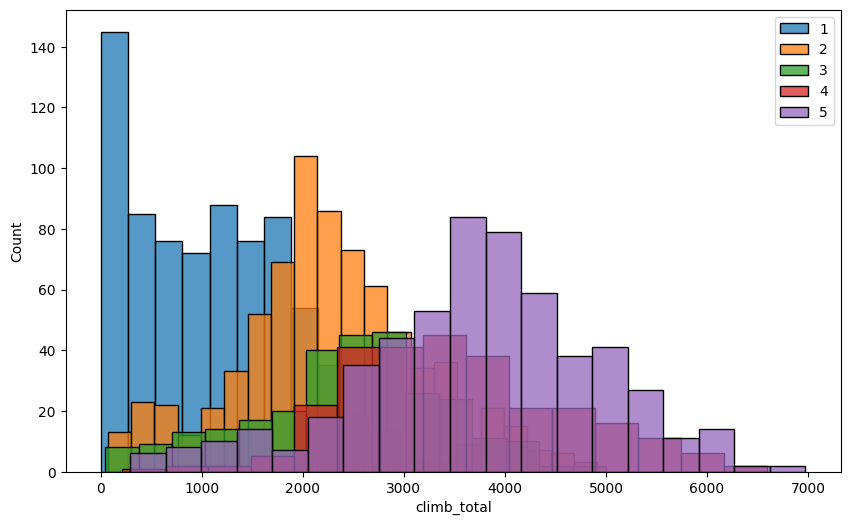

In [64]:
plt.figure(figsize=(10, 6))
for profile in [1, 2, 3, 4, 5]:
    sns.histplot(
        data=races_df.loc[races_df.profile == profile]
        .groupby("_url")[["profile", "climb_total"]]
        .first(),
        x="climb_total",
        label=profile,
    )
    plt.legend()

Look at correlation between the two

In [65]:
not_nan_df = races_df.loc[
    (races_df.profile.notna() & races_df.climb_total.notna())
]
print("not nan urls", not_nan_df._url.unique().shape)
not_nan_df = not_nan_df.groupby("_url")[
    ["_url", "profile", "climb_total"]
].first()
print(races_df._url.unique().shape)
print(not_nan_df._url.unique().shape)

print(not_nan_df.profile.corr(not_nan_df.climb_total, method="spearman"))
print(not_nan_df.profile.corr(not_nan_df.climb_total, method="kendall"))

not nan urls (2614,)
(5281,)
(2614,)
0.7196510433732758
0.572520132871134


the two columns are correlated (spearman > 0.7, kendall > 0.55)

In [66]:
true_races_df = races_df.groupby("_url")[["profile", "climb_total"]].first()
print(
    true_races_df.loc[
        (true_races_df.profile.notna() & true_races_df.climb_total.isna())
    ].shape
)
print(
    true_races_df.loc[
        (true_races_df.profile.isna() & true_races_df.climb_total.notna())
    ].shape
)

(259, 2)
(453, 2)


In [67]:
# tried median imputation but it changes the distribution of the data
# tried assigning value to class with closest median
"""medians = []
for i in range(1, 6):
    mask = true_races_df.profile == i
    medians.append(true_races_df.loc[mask, "climb_total"].median())

mask = true_races_df.profile.isna() & true_races_df.climb_total.notna()
temp_df = true_races_df.loc[mask]


for i, row in temp_df.iterrows():
    min_diff = float("inf")
    for j in range(5):
        diff = abs(row["climb_total"] - medians[j])
        if diff < min_diff:
            min_diff = diff
            profile = j + 1

    true_races_df.loc[i, "profile"] = profile"""

fit_df = true_races_df.loc[
    true_races_df.profile.notna() & true_races_df.climb_total.notna()
]
impute_df = true_races_df.loc[
    true_races_df.profile.notna() & true_races_df.climb_total.isna()
]

imputer = imp.KNNImputer(n_neighbors=5)
imputer.fit(fit_df)
imputation = imputer.transform(impute_df)
df_temp = pd.DataFrame(imputation, columns=["profile", "climb_total"])
df_temp.head()
true_races_df.loc[
    true_races_df.profile.notna() & true_races_df.climb_total.isna()
] = df_temp

In [68]:
print(
    true_races_df.loc[
        (true_races_df.profile.notna() & true_races_df.climb_total.isna())
    ].shape
)

(0, 2)


In [69]:
# Profile is a categorical variable
cat_imputer = imp.KNNImputer(n_neighbors=5)
cat_imputer.fit(fit_df)
impute_df = true_races_df.loc[
    true_races_df.profile.isna() & true_races_df.climb_total.notna()
]
imputation = cat_imputer.transform(impute_df)
imputation = np.round(imputation)
df_temp = pd.DataFrame(imputation, columns=["profile", "climb_total"])
true_races_df.loc[
    true_races_df.profile.isna() & true_races_df.climb_total.notna()
] = df_temp


In [70]:
print(
    true_races_df.loc[
        (true_races_df.profile.isna() & true_races_df.climb_total.notna())
    ].shape
)

(0, 2)


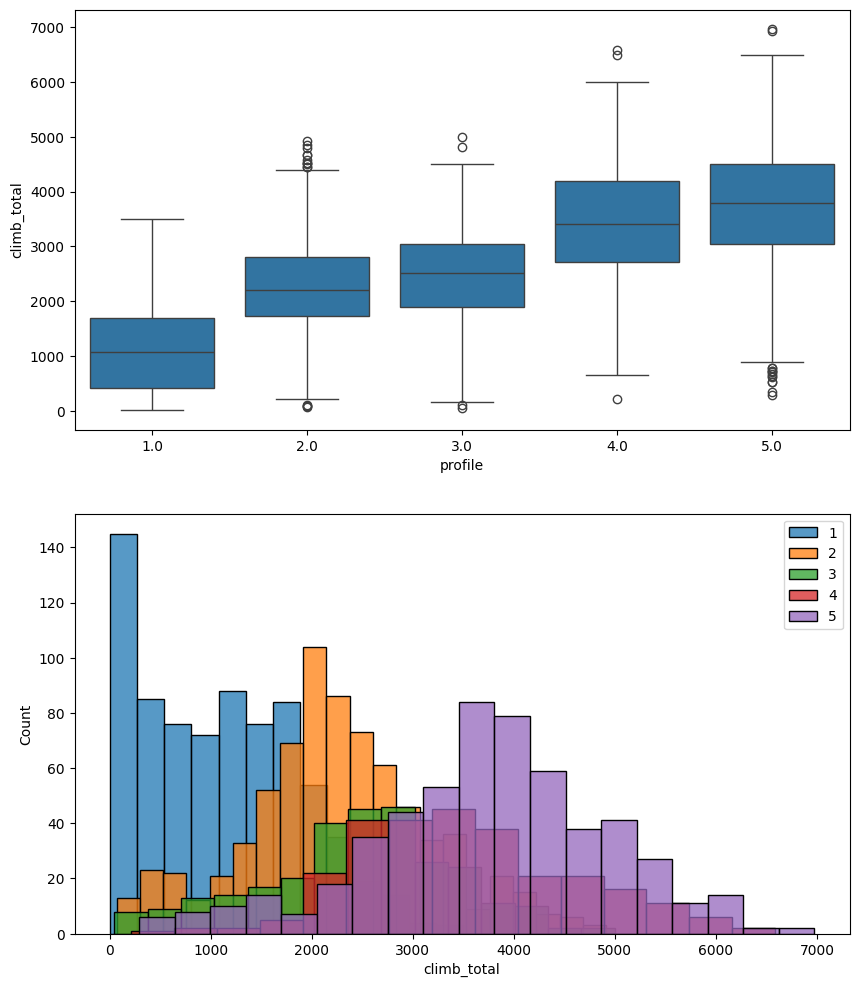

In [71]:
# see how distribution changed
plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)
sns.boxplot(data=true_races_df, x="profile", y="climb_total")
plt.subplot(2, 1, 2)
for profile in [1, 2, 3, 4, 5]:
    sns.histplot(
        data=true_races_df.loc[true_races_df.profile == profile],
        x="climb_total",
        label=profile,
    )
plt.legend()
plt.show()

### Look startlist quality

The startlist are integers representing how strong the lineup is. They are sparse.

In [14]:
races_df.startlist_quality.unique()[:100]

Now we can build the joined table and analyze the data together

In [15]:
class DataUnderstander:
    def __init__(self, races_csv, cyclist_csv, merged_csv=None):
        # So keep ref to all datasets and make one joined
        self.races_df = races_csv
        self.cyclist_df = cyclist_csv

        if merged_csv == None:
            self.df = pd.merge(
                self.races_df,
                self.cyclist_df,
                left_on="cyclist",
                right_on="_url",
                how="inner",
            )
        else:
            self.df = pd.read_csv(merged_csv, parse_dates=["date"])

        # Delete useless columns for the joined table
        self.delete_column("_url_y")
        self.delete_column("name_y")

        # Delete columns that are all false
        self.delete_column("is_cobbled")
        self.delete_column("is_gravel")

        # Rename to understand better
        self.df.rename(
            columns={
                "name_x": "location",
                "_url_x": "url",
            },
            inplace=True,
        )

        # dm.export_csv() # Save the merged version of dataset

    def delete_column(self, col):
        self.df.drop(columns=[col], inplace=True)

    def fill_nan(self, column, value):
        self.df[column].fillna(value, inplace=True)

    def export_csv(self):
        return self.df.to_csv("./dataset/dataset.csv")

    def correlate(self):
        correlations = {
            correlation_type: self.df.corr(
                numeric_only=True, method=correlation_type
            )
            for correlation_type in ("kendall", "pearson", "spearman")
        }

        for i, k in enumerate(correlations.keys()):
            correlations[k].loc[:, "correlation_type"] = k

        # Loop through each correlation type and create separate plots
        for corr_type, corr_matrix in correlations.items():
            corr_matrix = corr_matrix.drop(columns=["correlation_type"])

            # Create a new figure for each correlation type
            plt.figure(figsize=(12, 12))

            # Plot the heatmap
            sns.heatmap(
                corr_matrix,
                annot=True,
                cmap="coolwarm",
                fmt=".2f",
                linewidths=0.5,
            )

            # Set the title for the plot
            plt.title(f"{corr_type.capitalize()} Correlation")

            # Display the plot
            plt.show()

    def normalize(self):
        numeric_columns = [
            "points",
            "length",
            "climb_total",
            "profile",
            "startlist_quality",
            "cyclist_age",
            "delta",
            "birth_year",
            "weight",
            "height",
        ]
        scaler = StandardScaler()  # Si prova con la zscore ora eh
        self.df[numeric_columns] = scaler.fit_transform(
            self.df[numeric_columns]
        )

In [16]:
dm = DataUnderstander(races_df, cyclist_df)  # Initialize the datasets

In [17]:
dm.df.info()

In [18]:
# Try to fix missing birth_year or age using the other column. Nothing they always nan at the same time

ages = dm.df.groupby("cyclist")["cyclist_age"].unique()

ages = ages.apply(lambda x: np.isnan(x).all())
# names for which is true
ages = ages[ages == True].index

for idx, name in enumerate(ages):
    print(idx, name)
    print(cyclist_df.loc[cyclist_df._url == name].birth_year)

0 alexandr-osipov
2536   NaN
Name: birth_year, dtype: float64
1 antonio-zanini
894   NaN
Name: birth_year, dtype: float64
2 batik-odriozola
6080   NaN
Name: birth_year, dtype: float64
3 carlos-garcia
2515   NaN
Name: birth_year, dtype: float64
4 filippo-simonetti
2408   NaN
Name: birth_year, dtype: float64
5 javier-luquin
4384   NaN
Name: birth_year, dtype: float64
6 nevens-guy
3551   NaN
Name: birth_year, dtype: float64
7 nicolai-kosyakov
3046   NaN
Name: birth_year, dtype: float64
8 oscar-pumar
4142   NaN
Name: birth_year, dtype: float64
9 scott-davies
9    1995.0
Name: birth_year, dtype: float64
10 sergei-jermachenko
6072   NaN
Name: birth_year, dtype: float64
11 thierry-lauder
4756   NaN
Name: birth_year, dtype: float64
12 vladimir-malakov
601   NaN
Name: birth_year, dtype: float64


# Distribution analysis


To analyze the distribution the distribution we need to work on merged table but also on individual tables.
- **Cyclists table** is already ready.
- **Races table** is not ready. we need to group by race to analyze the attribute relative to a race.
- **Merged table** is not ready. we need to throw away columns relative to a single race (static attributes).

First of all let's retrieve the race table without duplicates of static attributes and plot the distributions

In [22]:
grouped_races_df = races_df.groupby(
    [
        "_url",
    ]
)[
    [
        "_url",
        "name",
        "points",
        "uci_points",
        "length",
        "climb_total",
        "profile",
        "startlist_quality",
        "date",
    ]
].apply(lambda x: x)

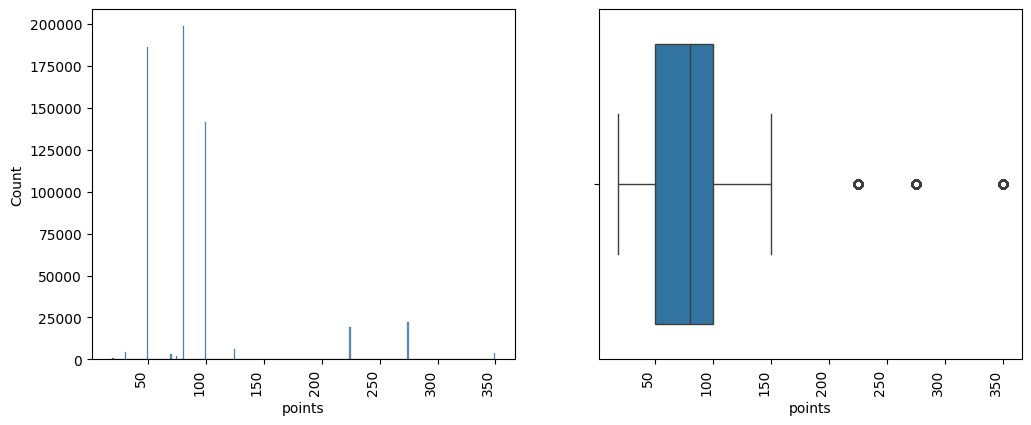

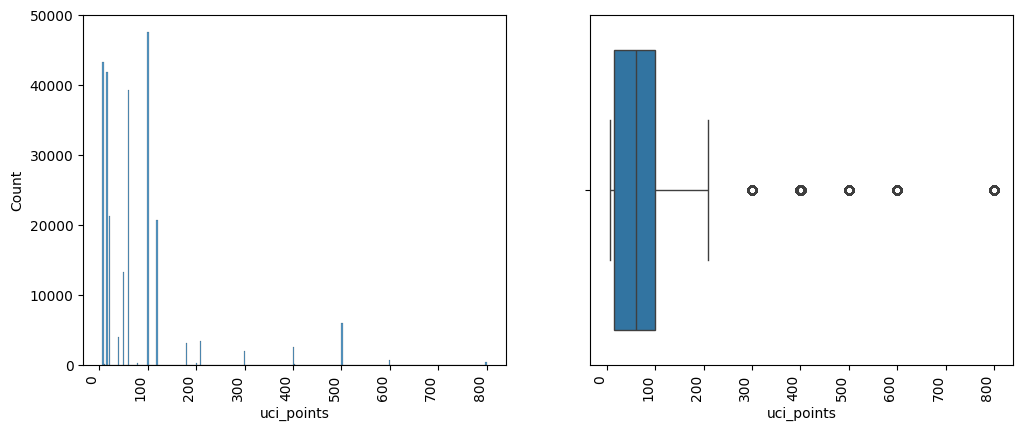

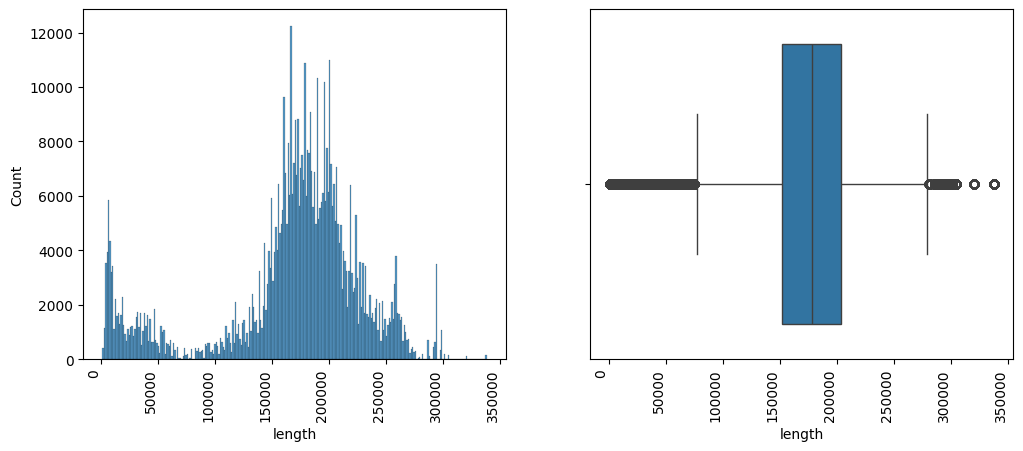

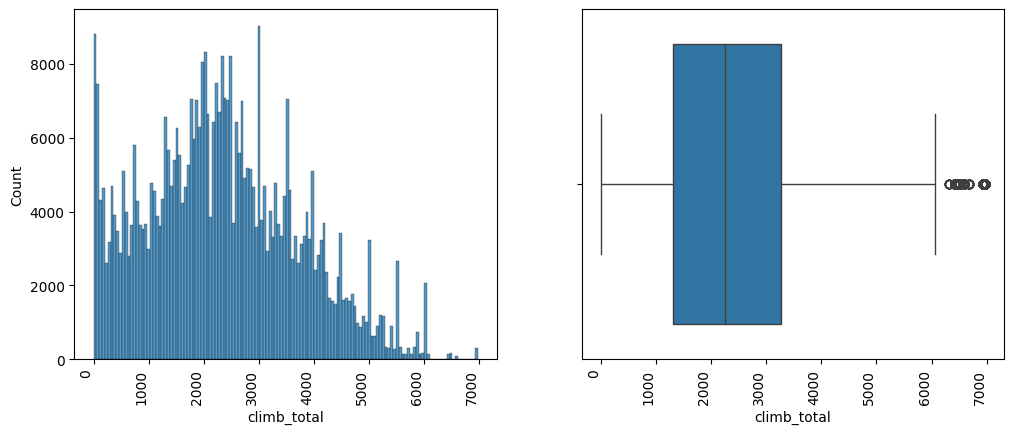

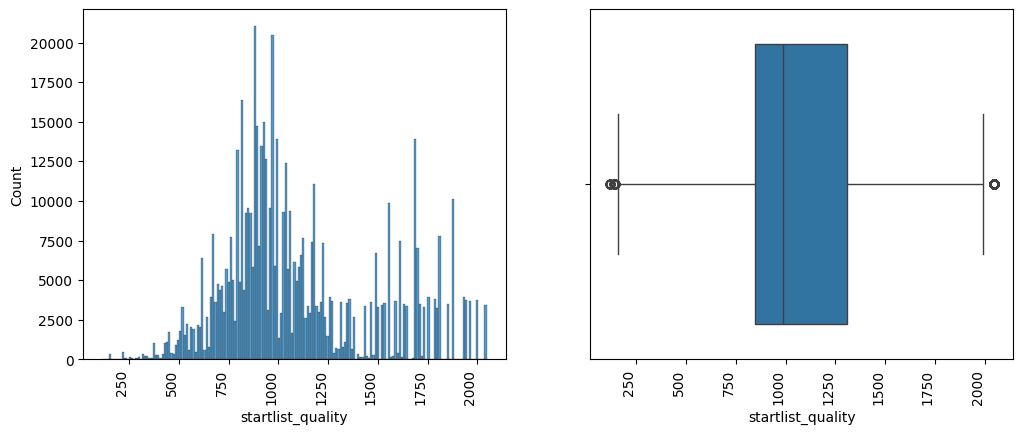

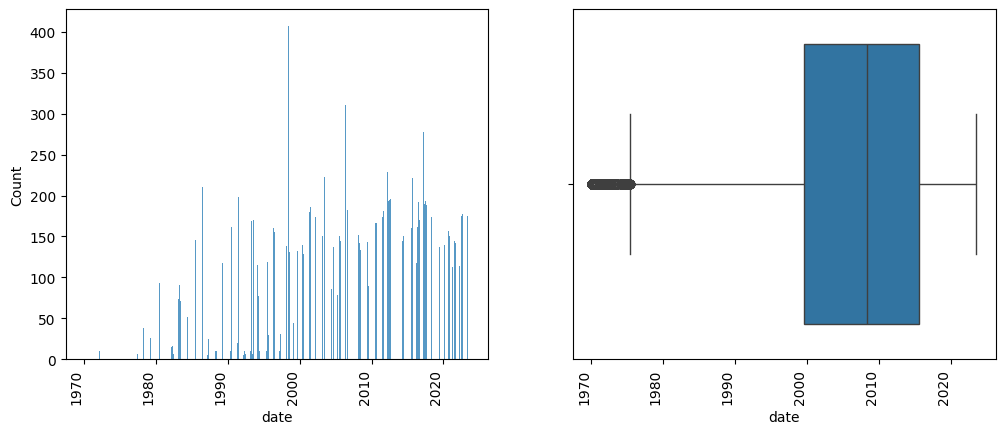

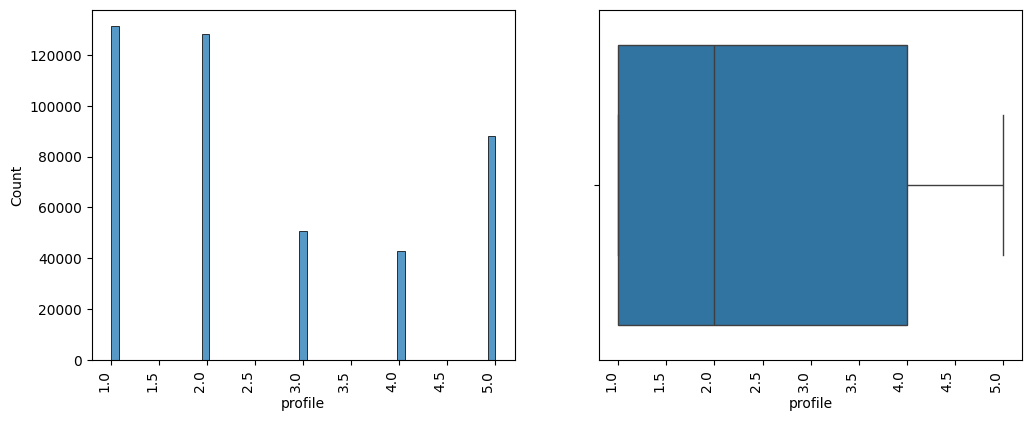

In [23]:
def plot(df, col, *args, **kwargs):
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)  # (rows, columns, index)
    sns.histplot(x=col, data=df, *args, **kwargs)
    plt.xticks(rotation=90, ha="right")
    plt.subplot(2, 2, 2)  # (rows, columns, index)
    sns.boxplot(x=col, data=df)
    plt.xticks(rotation=90, ha="right")
    plt.show()


plot(grouped_races_df, "points")
plot(grouped_races_df, "uci_points")
plot(grouped_races_df, "length")
plot(grouped_races_df, "climb_total")
plot(grouped_races_df, "startlist_quality")
plot(grouped_races_df, "date")
plot(grouped_races_df, "profile")

Text(0, 0.5, 'Delta')

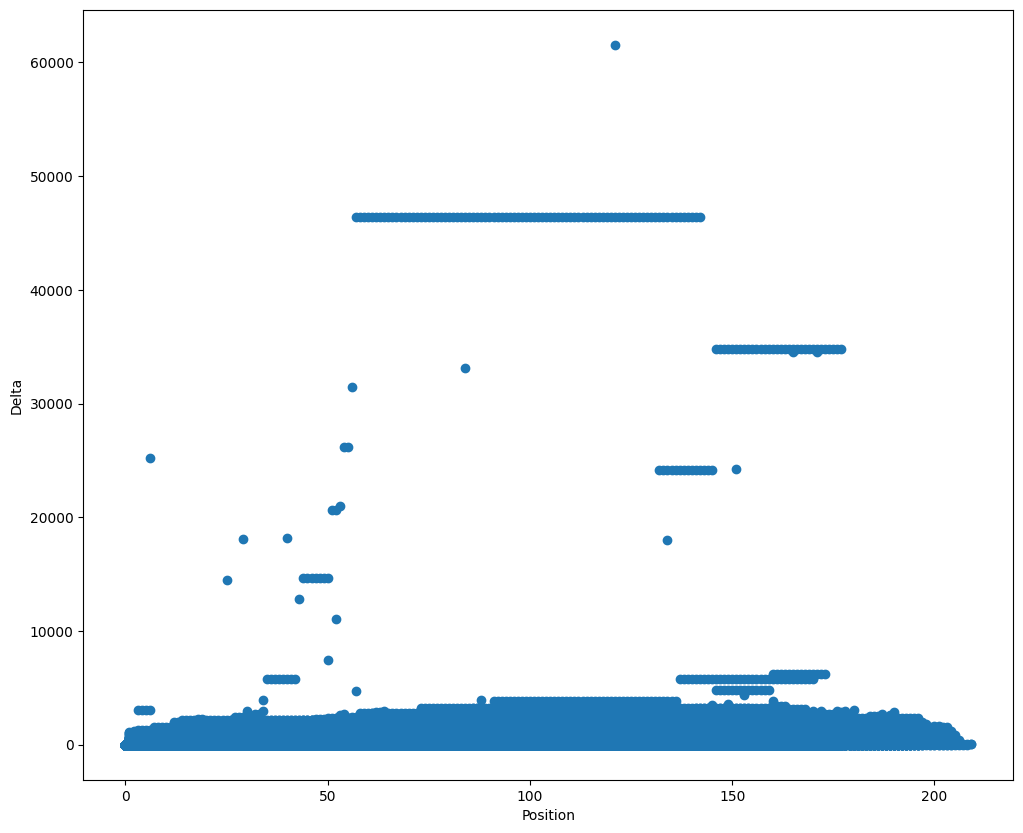

In [21]:
plt.figure(figsize=(12, 10))
plt.scatter(dm.df["position"], dm.df["delta"])
plt.xlabel("Position")
plt.ylabel("Delta")

Now we can do the same for the cyclist table. In his case we have also some categorical attributes to plot.

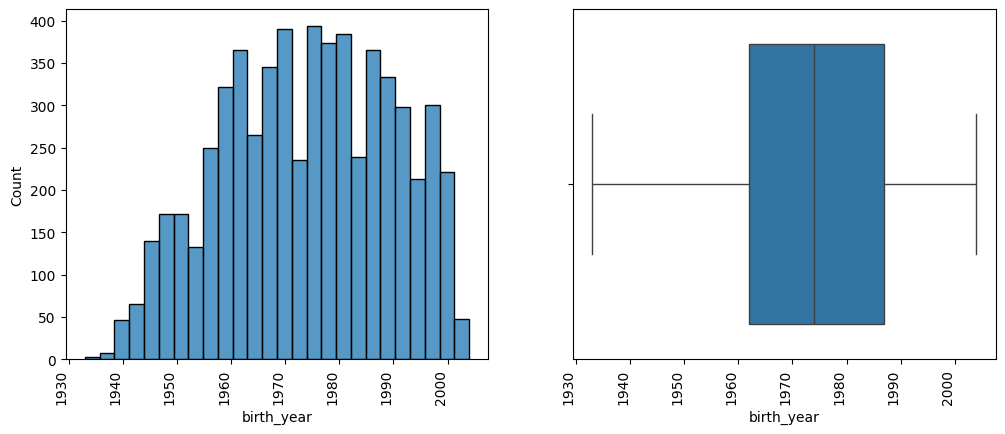

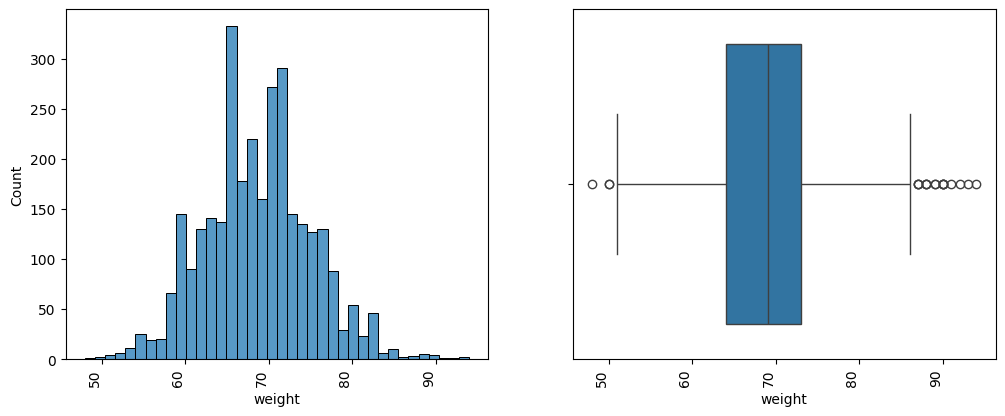

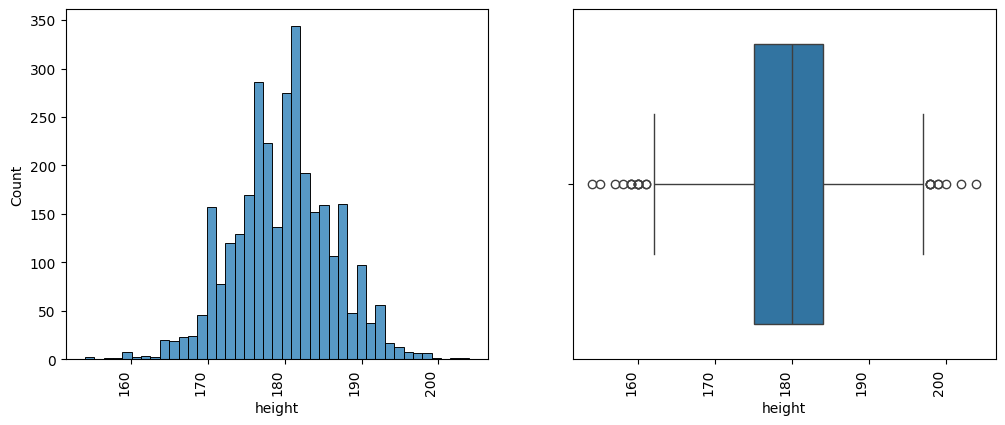

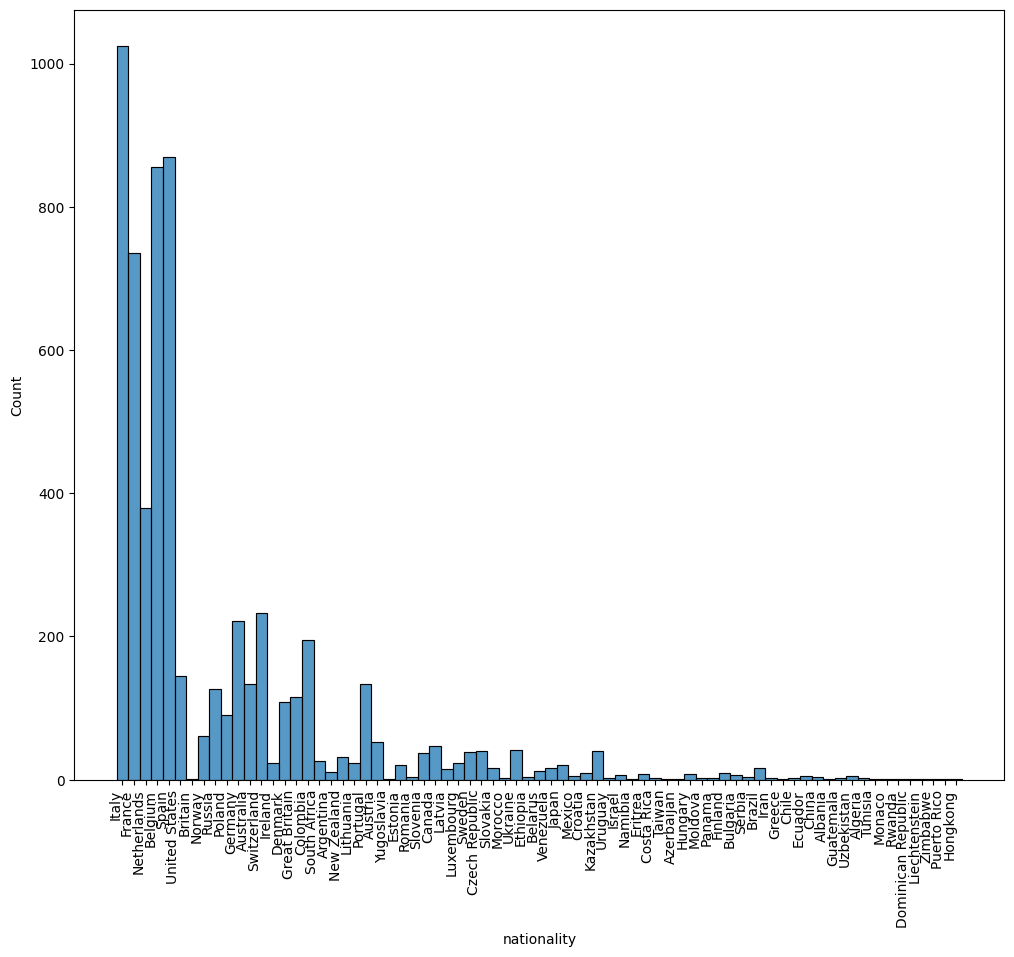

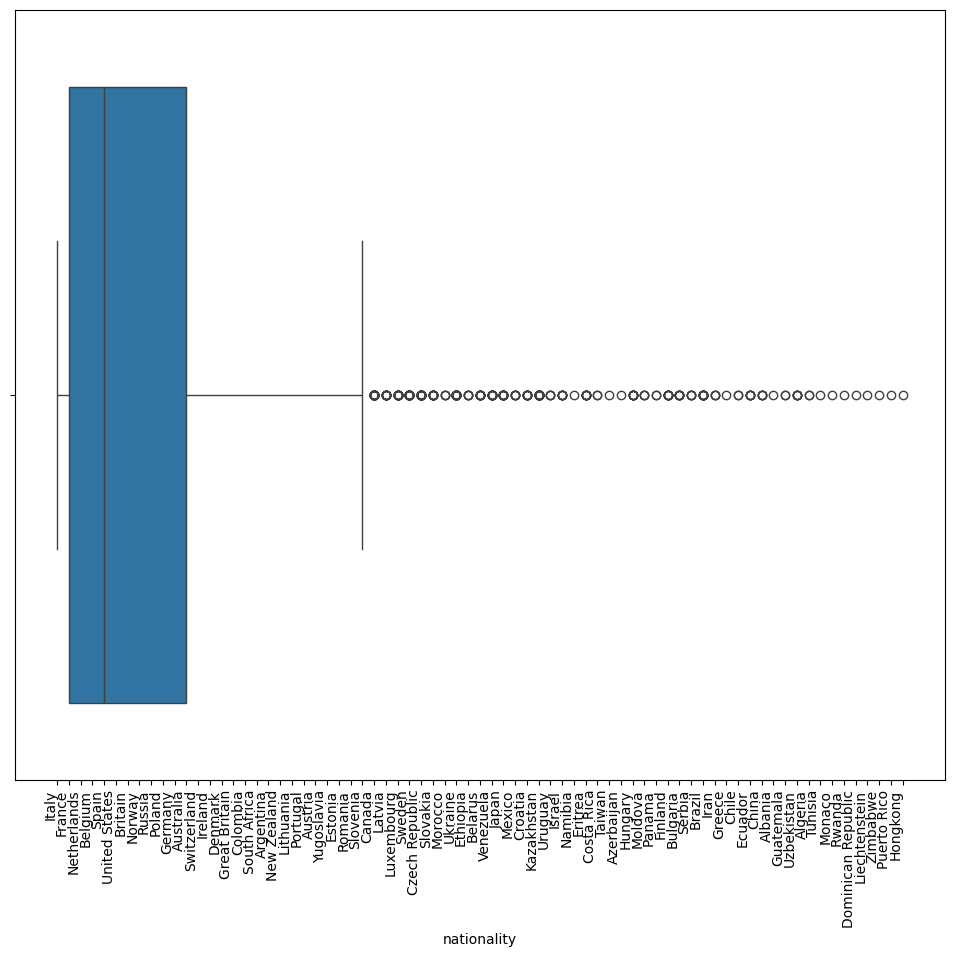

In [28]:
plot(cyclist_df, "birth_year")
plot(cyclist_df, "weight")
plot(cyclist_df, "height")


# Nationalities plot is very big. Let's split in two figures
def plot(df, col):
    plt.figure(figsize=(12, 10))
    sns.histplot(x=col, data=df)
    plt.xticks(rotation=90, ha="right")
    plt.show()
    plt.figure(figsize=(12, 10))
    sns.boxplot(x=col, data=df)
    plt.xticks(rotation=90, ha="right")
    plt.show()


plot(cyclist_df, "nationality")

Now we can analyze the attributes that are related both on race and on cyclist (Ex position)

Now we can build the build the correlation matrix to try to understand which columns are correlated.

In [22]:
dm.normalize()
dm.correlate()

In all the 3 plots we can observe:
- We can observe that the columns **climb_total** and **profile** are highly correlated, so we can use them to fix the missing values.
- We can observe that weight and height are highly correlated but we can expect this because it's naturally true.
- We can observe that **points** and **uci_points** are highly correlated.
- We can observe that **profile** and **delta** are correlated.
- We can observe that **climb_total** and **delta** are correlated.
- We can observe that **startlist_quality** and **points** are correlated.
- We can observe that **length** and **points** are correlated.
- We can observe that **birth_year** and **uci_points** are correlated.
Note: Normalizing the data does not affect the correlation matrix.

In [23]:
Alpha